### Pairs trading algorithm

Steps for pair trading: 

1 Find pairs 

2 Analyze pairs features

3 Trade

4 Optimize strategy

## Find Pairs

### Using Co-integration

In [20]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint

In [2]:
def find_cointegrated_pairs(data):
    n = data.shape[1] #number of tickers
    score_matrix = np.zeros((n,n)) #Scores
    pvalue_matrix = np.zeros((n,n)) #Holder for p-values
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1,n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            results = coint(S1, S2)
            score = results[0]
            pvalue = results[1]
            score_matrix[i,j] = score
            pvalue_matrix[i,j] = pvalue
            if pvalue < 0.02:
                pairs.append((keys[i], keys[j]))
    
    return score_matrix, pvalue_matrix, pairs

In [23]:
start_date = "2018-01-01"
end_date = "2020-10-30"

# Get data for stocks
tickers = ['PEP', 'KO', 'SPY','AAPL','ADBE','EBAY','MSFT','QCOM','HPQ','JNPR','AMD','IBM']
data = yf.download(tickers, start=start_date, end=end_date)

#Only take the closing price.
data = data["Adj Close"]

[*********************100%***********************]  12 of 12 completed


[('ADBE', 'AMD'),
 ('HPQ', 'PEP'),
 ('IBM', 'MSFT'),
 ('IBM', 'PEP'),
 ('IBM', 'QCOM'),
 ('QCOM', 'SPY')]

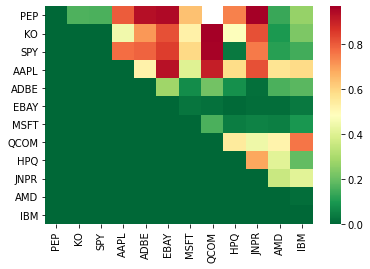

In [24]:
scores, pvalues, pairs = find_cointegrated_pairs(data)

seaborn.heatmap(pvalues, xticklabels=tickers, 
                yticklabels=tickers, cmap='RdYlGn_r', 
                mask = (pvalues >= 0.98))
pairs

In [25]:
def zscore(series):
    return (series - series.mean()) /np.std(series)

#### After analyzing the graphs, we can see that the only IBM and JNPR are the only series that do not go out of co integration

### Now split data into training and testing

In [27]:
ratio = data["KO"] / data["PEP"]
#split 70% of the total data into training
train_size = int(ratio.shape[0] * 0.7)

train_data = ratio[:train_size]
test_data = ratio[train_size:]

Now analyze the data using moving averages instead of single day data

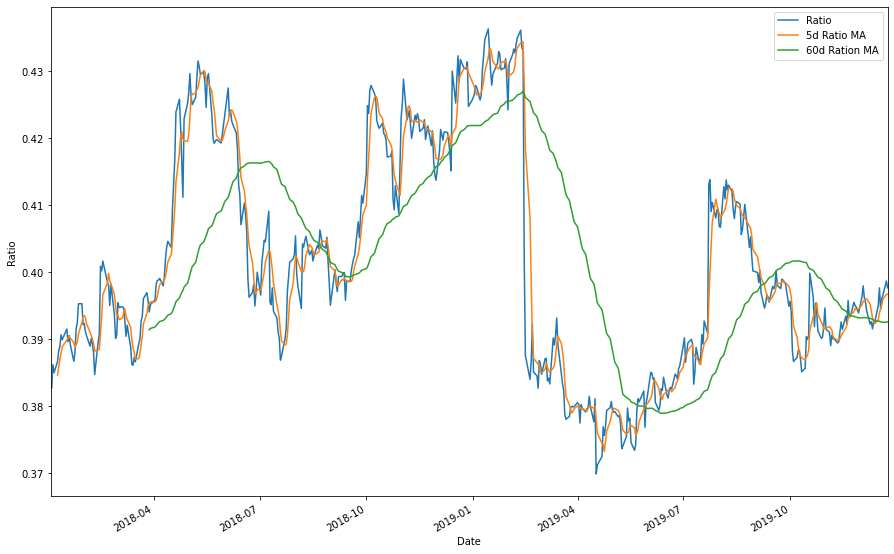

In [28]:
train_data_ma5 = train_data.rolling(window=5, center=False).mean()
train_data_ma60 = train_data.rolling(window=60, center=False).mean()
std_60 = train_data.rolling(window=60, center=False).std()

# This is the normalised ration.
z_score_60_5 = (train_data_ma5 - train_data_ma60)/std_60

plt.figure(figsize=(15,10))
train_data.plot()
train_data_ma5.plot()
train_data_ma60.plot()
plt.legend(['Ratio', "5d Ratio MA", "60d Ration MA"])
plt.ylabel("Ratio")
plt.show()

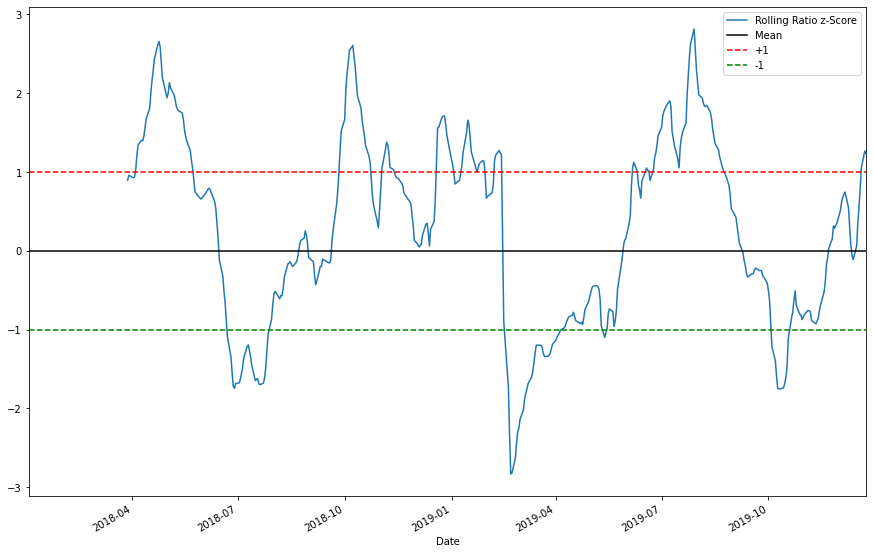

In [29]:
plt.figure(figsize=(15,10))
z_score_60_5 .plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

Check whether we see trading signals

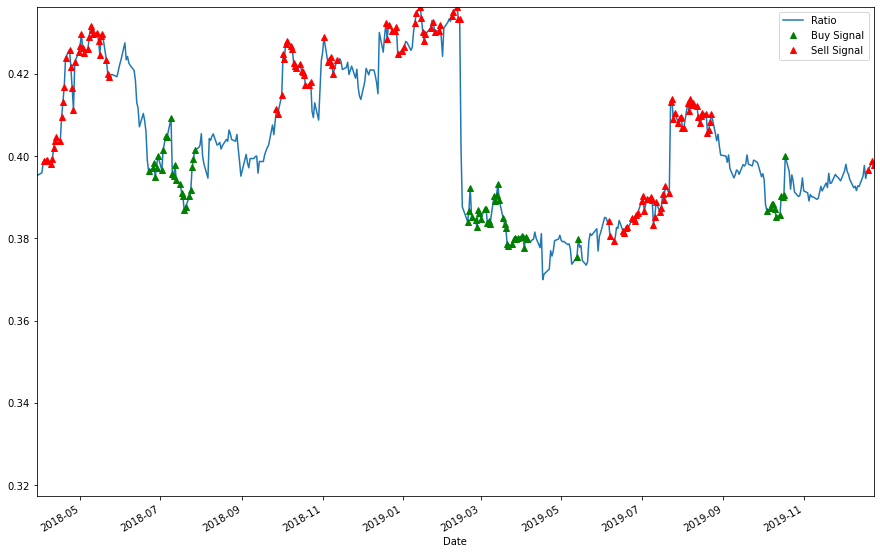

In [32]:
plt.figure(figsize=(15,10))

# Since we use 60-day MA, the first 60 values are not used
train_data[60:].plot()
buy = train_data.copy()
sell = train_data.copy()

#We do not buy nor sell when they are within the one standard deviation.
buy[z_score_60_5>-1] = 0
sell[z_score_60_5<1] = 0

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratio.min(), ratio.max()))

buy[60:].plot(color="g", linestyle="None", marker="^")
sell[60:].plot(color="r", linestyle="None", marker="^")
plt.legend(["Ratio", "Buy Signal", "Sell Signal"])

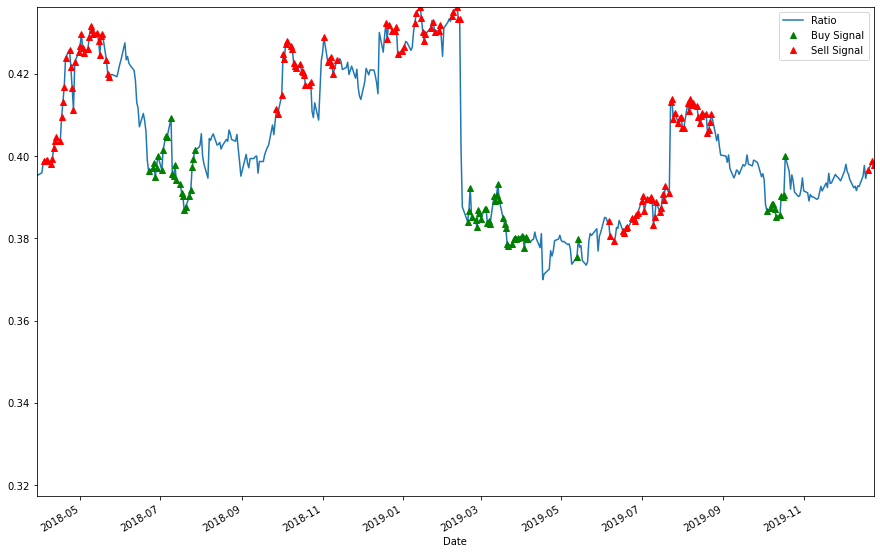

In [33]:
plt.figure(figsize=(15,10))

# Since we use 60-day MA, the first 60 values are not used
train_data[60:].plot()
buy = train_data.copy()
sell = train_data.copy()

#We do not buy nor sell when they are within the one standard deviation.
buy[z_score_60_5>-1] = 0
sell[z_score_60_5<1] = 0

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratio.min(), ratio.max()))

buy[60:].plot(color="g", linestyle="None", marker="^")
sell[60:].plot(color="r", linestyle="None", marker="^")
plt.legend(["Ratio", "Buy Signal", "Sell Signal"])

Check for each stock when they are bought and sold.

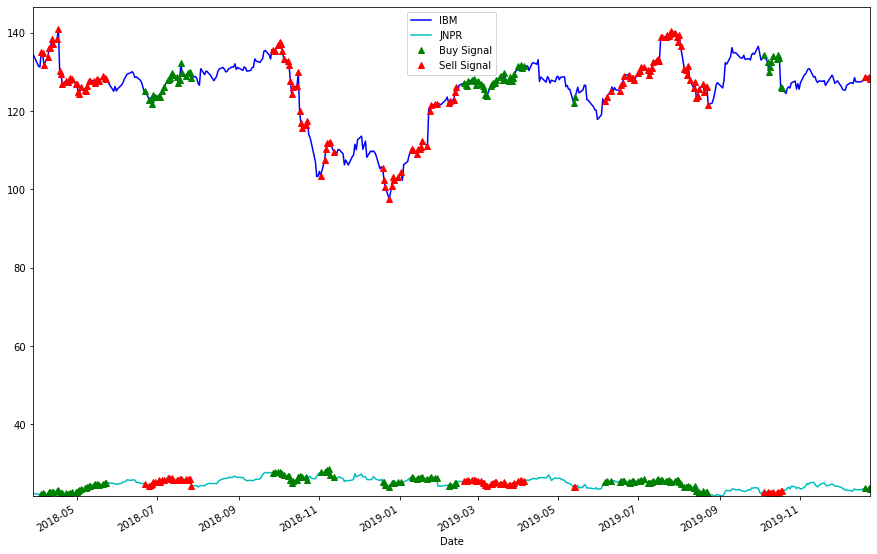

In [34]:
S1 = data["IBM"][:train_size]
S2 = data["JNPR"][:train_size]

plt.figure(figsize=(15,10))
S1[60:].plot(color="b")
S2[60:].plot(color="c")
buyR = 0*S1.copy()
sellR = 0*S2.copy()

# When buying the ratio, buy S1 and sell S2
buyR[buy != 0] = S1[buy != 0]
sellR[buy != 0] = S2[buy != 0]
# When selling the ratio, sell S1 and buy S2
buyR[sell != 0] = S2[sell != 0]
sellR[sell != 0] = S1[sell != 0]

buyR[60:].plot(color="g", linestyle="None", marker="^")
sellR[60:].plot(color="r", linestyle="None", marker="^")
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))


plt.legend(["IBM", "JNPR", "Buy Signal", "Sell Signal"])
plt.show()

This makes sense, we should have opposite signals for the different stocks.

Now we should create a trading strategy.

In [35]:
def trade(S1, S2, window1, window2):
    if (window1 == 0) or (window2 == 0):
        return 0
    
    spread = S1/S2
    ma1 = spread.rolling(window=window1, center=False).mean()
    ma2 = spread.rolling(window=window2, center=False).mean()
    
    std = spread.rolling(window=window2, center=False).std()
    
    zscore = (ma1 - ma2)/std
    
    #Simulate trading
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(spread)):
        if zscore[i] > 1:
            money += S1[i] - S2[i] * spread[i]
            countS1 -= 1
            countS2 += spread[i]
            #print('Selling Spread %s %s %s %s'%(money, spread[i], countS1,countS2))
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * spread[i]
            countS1 += 1
            countS2 -= spread[i]
            #print('Buying Spread %s %s %s %s'%(money, spread[i], countS1,countS2))

        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1  + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            #print('Exit pos %s %s %s %s'%(money, spread[i], countS1,countS2))
    return money

In [36]:
trade(data["IBM"].iloc[:train_size], data["JNPR"].iloc[:train_size], 5, 100)

1085.3438376260847

In [18]:
#find best windows
best_window = 15
money = trade(data["IBM"].iloc[:train_size], data["JNPR"].iloc[:train_size], 10, 150)
for i in range(best_window, 200):
    money_ = trade(data["IBM"].iloc[:train_size], data["JNPR"].iloc[:train_size], 10, i)
    if money_ > money:
        best_window = i
        money = money_

best_window, money

(181, 1347.1024202327244)

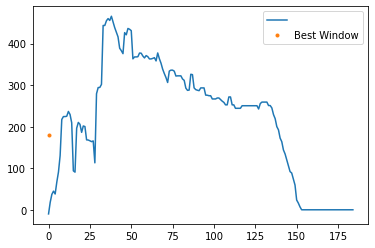

In [37]:
y = [ trade(data["IBM"].iloc[train_size:], data["JNPR"].iloc[train_size:], 5, i) for i in range(15,200) ]
plt.plot(y)
plt.plot(best_window, linestyle="None", marker=".")
plt.legend(["", "Best Window"])

Trying different windows, we can see that the best window for training is not often the best window for testing (overfitting).

We should study what makes the choice of window valid and good.

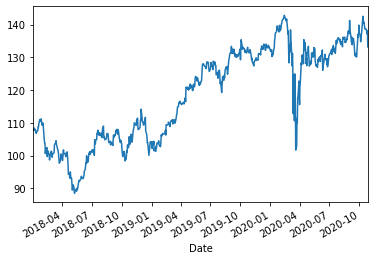

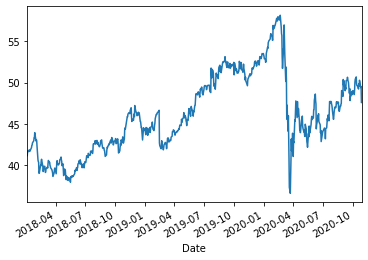

In [38]:
data["PEP"].plot()
plt.show()
data["KO"].plot()

In [39]:
coint(data["KO"],data["PEP"])

(-2.1705130679578004,
 0.4396172813385739,
 array([-3.91188802, -3.34472506, -3.05041211]))